# Imagine you have a dataset where you have different categories of data, Now you need to find the most similar data to the given data by using any 4 different similarity algorithms. Now you have to build a model which can find the most similar data to the given data.

In [69]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

In [70]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [71]:
df= df.iloc[:10000,:]

In [72]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [73]:
df.duplicated().sum()

0

In [74]:
df.drop_duplicates(inplace=True)

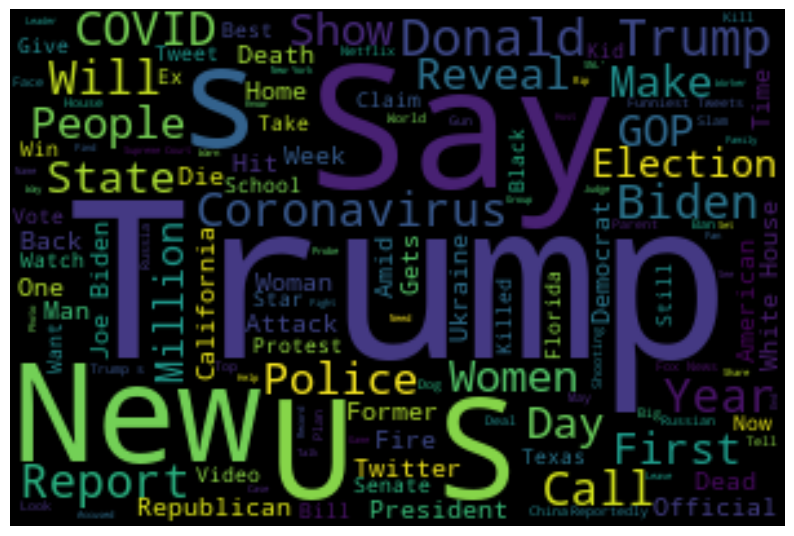

In [75]:
#Word cloud visualization
text=" ".join(i for i in df.headline)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 300, height = 200, stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [76]:
#Concatenating the headline and the short description column
df["news_text"] =df["headline"] + " " + df["short_description"] 

In [77]:
#Drop unnused columns from the dataset
df=df.drop(columns=["link", "authors", "category", "date", "short_description"])

In [78]:
en_stopwords =stopwords
lemmatizer = WordNetLemmatizer()

In [79]:
#Defining th preprocessing function
def process(text):
    text = re.sub("[^A-Za-z1-9 ]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    clean_list = []
    for token in tokens:
        if token not in en_stopwords:
            clean_list.append(lemmatizer.lemmatize(token))
    return " ".join(clean_list)

In [80]:
df.news_text = df.news_text.apply(process)

In [81]:
vectorizer = TfidfVectorizer()
features   = vectorizer.fit_transform(df['news_text'])

In [82]:
#Taking the cosine similarity of the vectorized text
cosine_sim = cosine_similarity(features,features)

In [92]:
def get_recommended(headline_index, cosine_sim):
    headline=df.headline[headline_index]
    indices = pd.Series(df.index, index=df['headline']).drop_duplicates()
    # Get index of the news headline
    idx = indices[headline]
    # Sort the news headline on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar news headlines
    sim_scores = sim_scores[1:11]
    # Get the headline indices
    scores=[i[1] for i in sim_scores]
    news_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar news headlines
    dfs=pd.DataFrame({'headlines': df['headline'].iloc[news_indices],
                'Cosine_similarity':  scores})
    print("*" * 30 + " News Recommendation " + "*" * 30)
    print("")
    print(f"News Headline: {headline}")
    print("")
    print( "*" * 29 + " Recommended News Articles " + "*" * 29)
    return dfs.iloc[0:,]

In [93]:
pd.set_option('display.max_colwidth', None)  # To display a very long headline completely

In [94]:
recommended=get_recommended(44, cosine_sim)
recommended

****************************** News Recommendation ******************************

News Headline: Mark Meadows Complies With Justice Dept. Subpoena: Report

***************************** Recommended News Articles *****************************


,headlines,Cosine_similarity
763,Mark Meadows Says Jan. 6 Panel Leaked Texts To 'Vilify' Him,0.318716
1485,House Moves Forward With Criminal Charges Against Mark Meadows,0.299706
1509,Mark Meadows Hands Over PowerPoint Plan For Trump To Overthrow Election,0.263359
3988,"Trump Went Through 'Very Concerning' Period After COVID-19 Diagnosis, White House Reveals",0.259851
1337,"Laura Ingraham Feared More Violence After Jan. 6, Newly Released Text Message Shows",0.235454
3804,North Carolina Republican Madison Cawthorn Will Soon Be The Youngest House Member,0.224868
1465,Michael Cohen Slams 'Stupid' Mark Meadows On MSNBC,0.212050
1449,Judge Denies Michael Flynn's Attempt To Block Subpoena For Phone Records In Jan. 6 Probe,0.200974
766,Samantha Bee Stunned By 'Gossipy Little Bitch' Mark Meadows' Text Messages,0.198799
862,DOJ Denies Jan. 6 Panel Details In Trump Records Probe,0.179023
